In [2]:
# ячейка для загрузки библиотек, служебных команд и функций
from google.colab import drive

import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import  Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall


warnings.simplefilter(action='ignore')
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR_TRAIN = "/content/drive/MyDrive/quests/k_ch/train_dataset_train/train/"
DIR_TEST = "/content/drive/MyDrive/quests/k_ch/test_dataset_test/test/"

PATH_TRAIN = "/content/drive/MyDrive/quests/k_ch/train_dataset_train/train.csv"
PATH_TEST = "/content/drive/MyDrive/quests/k_ch/test_dataset_test/test.csv"

RND_ST = 2307

In [4]:
labels = pd.read_csv(PATH_TRAIN)

In [5]:
labels.head()

,ID_img,class
0,2138.jpg,4.0
1,2139.jpg,6.0
2,2140.jpg,3.0
3,2141.jpg,6.0
4,2142.jpg,3.0


In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=DIR_TRAIN,
        x_col='ID_img',
        y_col='class',
        target_size=(210, 210),
        batch_size=32,
        class_mode='raw',
        seed=RND_ST)

Found 4990 validated image filenames.


In [14]:
train_datagen_flow.n

4990

In [15]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID_img  4990 non-null   object 
 1   class   4990 non-null   float64
dtypes: float64(1), object(1)
memory usage: 78.1+ KB


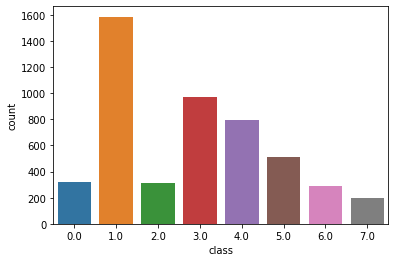

In [16]:
sns.countplot(x = "class" , data  = labels)

In [17]:
weights = labels['class'].value_counts(normalize=True).to_dict()
weights

{1.0: 0.31783567134268537,
 3.0: 0.194188376753507,
 4.0: 0.1597194388777555,
 5.0: 0.10300601202404809,
 0.0: 0.06432865731462926,
 2.0: 0.06332665330661323,
 6.0: 0.05871743486973948,
 7.0: 0.038877755511022044}

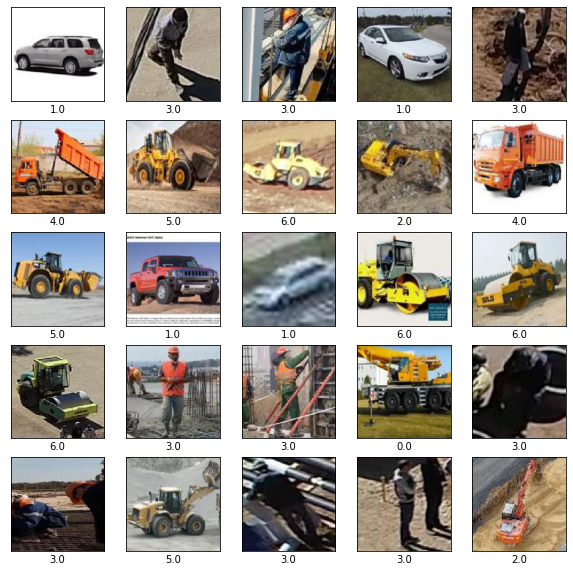

In [18]:
x, y  = train_datagen_flow.next()
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i], cmap=plt.cm.binary)
    plt.xlabel(y[i])
plt.show()

In [19]:
def load_train(DIR_TRAIN=DIR_TRAIN, PATH_TRAIN=PATH_TRAIN):
    labels = pd.read_csv(PATH_TRAIN)
    datagen = ImageDataGenerator(validation_split=0.30,
                                 rescale=1./255,
                                 # vertical_flip=True,
                                 horizontal_flip=True,
                                 rotation_range=30,
                                 width_shift_range=0.21,
                                 height_shift_range=0.21,
                                 shear_range=0.21,
                                 zoom_range=0.21
                                 )
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=DIR_TRAIN,
        x_col='ID_img',
        y_col='class',
        target_size=(210, 210),
        batch_size=32,
        class_mode='raw',
        subset='training',
        weght_col = weights,
        seed=2307)
    return train_gen_flow

In [20]:
def load_valid(DIR_TRAIN=DIR_TRAIN, PATH_TRAIN=PATH_TRAIN):
    labels = pd.read_csv(PATH_TRAIN)
    datagen = ImageDataGenerator(validation_split=0.30,
                                 horizontal_flip=True,
                                 rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=DIR_TRAIN,
        x_col='ID_img',
        y_col='class',
        target_size=(210, 210),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        weght_col = weights,
        shuffle=False,
        seed=2307)
    return test_gen_flow

In [21]:
def create_model(input_shape=(210, 210, 3)):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(8, activation='softmax'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
gc.collect()

8136

In [22]:
X_train = load_train()

Found 3493 validated image filenames.


In [23]:
X_valid = load_valid()

Found 1497 validated image filenames.


In [114]:
my_model = create_model()

In [115]:
my_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 23,604,104
Trainable params: 23,550,984
Non-trainable params: 53,120
_________________________________________________________________


In [24]:
steps_per_epoch = X_train.n//X_train.batch_size
validation_steps = X_valid.n//X_valid.batch_size

In [25]:
print(steps_per_epoch)
validation_steps

109


46

In [118]:
earlystop = EarlyStopping(patience=9)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.9, 
                                            min_lr=0.00001)
model_checpoint = ModelCheckpoint(
        filepath='/content/drive/MyDrive/quests/k_ch/33_{epoch}.h5',
        # Путь по которому нужно сохранить модель
        # Два параметра ниже значат что мы перезапишем
        # текущий чекпоинт в том и только в том случае, когда
        # улучится значение `val_loss`.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
callbacks = [earlystop, learning_rate_reduction, model_checpoint]

In [ ]:
my_model.fit(X_train, validation_data = X_valid, batch_size=32, epochs=50,class_weight=weights,
             steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.7972
Epoch 1: val_accuracy improved from -inf to 0.16984, saving model to /content/drive/MyDrive/quests/k_ch/33_1.h5
109/109 [==============================] - 59s 491ms/step - loss: 0.0624 - accuracy: 0.7972 - val_loss: 2.3265 - val_accuracy: 0.1698 - lr: 1.0000e-04
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9220
Epoch 2: val_accuracy did not improve from 0.16984
109/109 [==============================] - 51s 470ms/step - loss: 0.0246 - accuracy: 0.9220 - val_loss: 2.3584 - val_accuracy: 0.1053 - lr: 1.0000e-04
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9558
Epoch 3: val_accuracy improved from 0.16984 to 0.31386, saving model to /content/drive/MyDrive/quests/k_ch/33_3.h5
109/109 [==============================] - 53s 482ms/step - loss: 0.0145 - accuracy: 0.9558 - val_loss: 2.9605 - val_accuracy: 0.313

In [36]:
my_model = load_model('/content/drive/MyDrive/quests/k_ch/_33_22.h5')

In [37]:
scores = my_model.evaluate(X_valid, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 98.40%


In [ ]:
#my_model.save("/content/drive/MyDrive/quests/k_ch/res50_9359.h5")

In [38]:
test_df = pd.read_csv(PATH_TEST)

In [39]:
test_df = test_df.drop(["class"], axis = 1)
test_df.head()

,ID_img
0,0.jpg
1,1.jpg
2,2.jpg
3,3.jpg
4,4.jpg


In [40]:
nb_samples = test_df.shape[0]
nb_samples

2138

In [41]:
datagen = ImageDataGenerator(rescale=1./255)

test_gen_flow = datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=DIR_TEST,
        x_col='ID_img',
        y_col=None,
        target_size=(128, 128),
        batch_size=32,
        class_mode=None,
        shuffle=False,
        seed=2307)

Found 2138 validated image filenames.


In [ ]:
# predicts = []

# for imgs in tqdm(test_gen_flow):
#     pred = my_model.predict(imgs)
#     for class_obj in pred:
#       index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
#       predicts.append(index)

In [42]:
predict = my_model.predict_generator(test_gen_flow, steps=np.ceil(nb_samples/32))

In [43]:
test_df["class"] = np.argmax(predict, axis=-1)

In [44]:
test_df.head()

,ID_img,class
0,0.jpg,5
1,1.jpg,5
2,2.jpg,1
3,3.jpg,1
4,4.jpg,6


In [46]:
test_df.to_csv("/content/drive/MyDrive/quests/k_ch/submit9840.csv", index=False)